### Assessing motif-wise accuracy

In [ ]:
#getting motif-wise prediction accuracy
g_preds = []
for g in glycans:
  subset = custom_df2[custom_df2.glycan==g]
  subset = subset[subset.match==1].reset_index(drop=True)
  g_preds.append(np.mean([get_preds(p, [g]).predicted_presence.values.tolist()[0] for p in subset.seq_window_aa.values.tolist()]))
motifs['acc'] = g_preds

out = {}
for c in motifs.columns.tolist()[:-1]:
  out[c] = motifs.groupby(c).acc.mean()[True]
out = pd.DataFrame(out, index=[0]).T
out.columns = ['Accuracy']
sub_df = custom_df2[custom_df2.match==1].glycan.values.tolist()
out['Occurrence'] = [sum([sub_df.count(j) for j in motifs[motifs[i]==True].index.tolist()]) for i in out.index.tolist()]
#out.to_csv(fp + "fig2AB.csv")

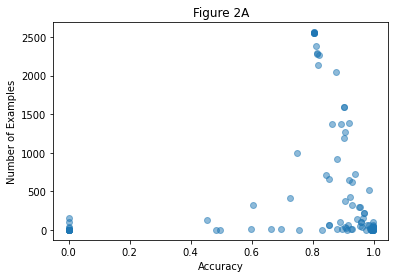

In [ ]:
plt.scatter(out.Accuracy, out.Occurrence, alpha = 0.5)
plt.xlabel("Accuracy")
plt.ylabel("Number of Examples")
plt.title("Figure 2A")
plt.savefig(fp+'fig2A.svg', format='svg',dpi=300,bbox_inches='tight')

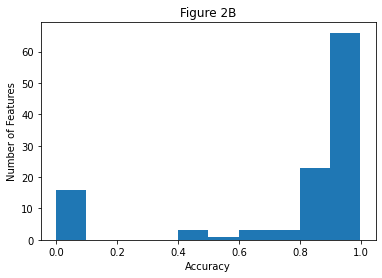

In [ ]:
plt.hist(out.Accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Number of Features")
plt.title("Figure 2B")
#plt.savefig(fp+'fig2B.svg', format='svg',dpi=300,bbox_inches='tight')

### Learned glycan representations

In [ ]:
#getting learned glycan representations
glycan_reps, _ = get_preds([21], glycans, inference = True)
glycan_reps = np.array(glycan_reps)
tsne_emb = TSNE(random_state=42, init = 'pca', learning_rate='auto').fit_transform(glycan_reps)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


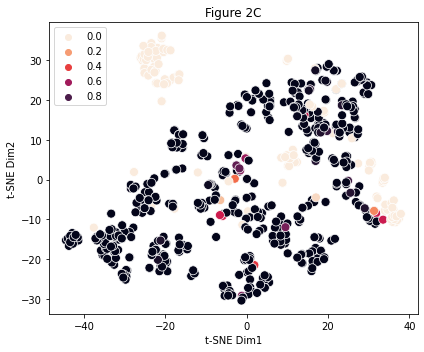

In [ ]:
plt.figure(figsize = (6, 5))
sns.scatterplot(tsne_emb[:,0], tsne_emb[:,1], s = 80, alpha = 1,
                hue = motifs.acc.values.tolist(), palette="rocket_r")
plt.title('Figure 2C')
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.tight_layout()
#plt.savefig(fp+'fig2C.svg', format='svg',dpi=300,bbox_inches='tight')

In [ ]:
_#only if you want to have an interactive plot with glycan info upon hovering over the datapoint
!pip install phantomjs
!pip install selenium
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.models import ColumnDataSource, HoverTool
import selenium
import phantomjs

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 983 kB 6.4 MB/s 
     |████████████████████████████████| 138 kB 57.3 MB/s 
     |████████████████████████████████| 358 kB 46.7 MB/s 
     |████████████████████████████████| 4.0 MB 46.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascie

In [ ]:
source = ColumnDataSource(data = dict(x = tsne_emb[:,0], y = tsne_emb[:,1],
                                      desc = glycans))
p = figure(tools = 'hover')
radii = np.random.random(size = len(tsne_emb)) * 1.5
p.circle('x', 'y', fill_alpha = 0.5, source = source, size = 8, line_color = None)
hover = p.select(dict(type = HoverTool))
hover.tooltips = [
        ("Glycan", "@desc")
        ]

show(p)

## Learned protein representations

In [ ]:
#getting learned protein representations
p_preds = []
custom_df2.seq_window_aa = [tuple(k) for k in custom_df2.seq_window_aa.values.tolist()]
prots = list(set(custom_df2.seq_window_aa.values.tolist()))
for p in prots:
  subset = custom_df2[custom_df2.seq_window_aa==p]
  subset = subset[subset.match==1].reset_index(drop=True)
  p_preds.append(np.mean([get_preds(list(p), [g]).predicted_presence.values.tolist()[0] for g in subset.glycan.values.tolist()]))

_, prot_reps = zip(*[get_preds(list(p), ['Man'], inference = True) for p in prots])
prot_reps = np.array(prot_reps)
tsne_emb = TSNE(random_state=42, init = 'pca', learning_rate='auto').fit_transform(np.squeeze(prot_reps, axis=1))

temp = pd.DataFrame(np.squeeze(prot_reps, axis=1))
prots2 = [list(k) for k in prots]
prots2 = [''.join([chars[m] for m in k if m!=21]) for k in prots2]
temp.index=prots2
#temp.to_csv(fp + "fig2D.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


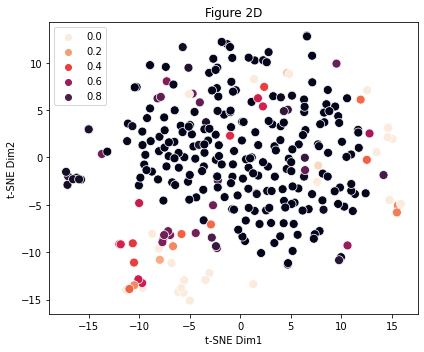

In [ ]:
plt.figure(figsize = (6, 5))
sns.scatterplot(tsne_emb[:,0], tsne_emb[:,1], s = 80, alpha = 1,
                hue = p_preds, palette="rocket_r")
plt.title('Figure 2D')
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.tight_layout()
#plt.savefig(fp+'fig2D.svg', format='svg',dpi=300,bbox_inches='tight')

## Uromodulin sequon

In [ ]:
#getting predictions for the uromodulin sequon
ex = string_to_labels('GTVLTRNETHATYS', libr = chars)
preds = get_preds([ex], glycans)
preds = preds.sort_values(by='predicted_presence', ascending=True)

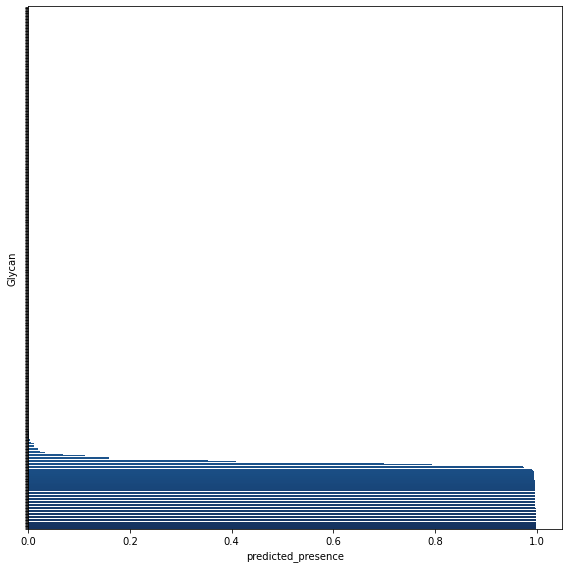

In [ ]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(x='predicted_presence', y='Glycan', data=preds, dodge=False, palette = "Blues")
ax.set_yticklabels('')
plt.tight_layout()
#plt.savefig(fp+'fig2E.svg', format='svg',dpi=300,bbox_inches='tight')

## Mutating sequon

In [ ]:
#mutating amino acids in the sequon and assessing effect on prediction
from functools import reduce

def mutate_sequon(sequon, glycs, muty, thresh = 0.2):
  outy = []
  temp = get_preds(sequon, glycs)
  temp.columns = ['Glycan', 'predicted_presence']
  outy.append(temp)
  muty_k = chars.index(muty)
  for k in range(len(sequon)):
    if sequon[k]!=muty_k:
      new_sequon = copy.deepcopy(sequon)
      new_sequon[k] = chars.index(muty)
      df_temp = get_preds(new_sequon, glycs)
      df_temp.columns = ['Glycan', 'predicted_presence_'+str(k)]
      outy.append(df_temp)
  df_out = pd.concat(outy, axis=1)
  df_out = df_out.loc[:,~df_out.columns.duplicated()]
  df_out.iloc[:,1:] = df_out.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
  df_var = df_out.loc[np.ptp(df_out.iloc[:,1:].values, axis=1)>thresh, :]
  df_var.reset_index(drop=True, inplace=True)
  return df_out, df_var

custom_df2.seq_window_aa = [tuple(k) for k in custom_df2.seq_window_aa.values.tolist()]
prots = list(set(custom_df2.seq_window_aa.values.tolist()))
prots = [list(k) for k in prots]
dfs = [mutate_sequon(k, glycans, 'E')[0] for k in prots]
df_out = pd.concat(dfs).mean(level=0)
df_out.index = glycans
#df_out.to_csv(fp+'changes_E_mutation_sequon.csv')

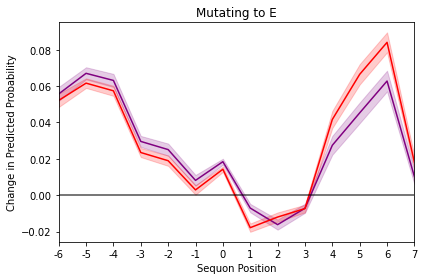

In [ ]:
import statsmodels.stats.api as sms

aa = 'E'
df_collect = pd.read_csv(fp + 'changes_'+aa+'_mutation_sequon.csv')
df_collect.index = df_collect.iloc[:,0]
df_collect.drop(df_collect.columns[0], axis=1, inplace=True)
for col in df_collect.columns.tolist()[1:]:
  df_collect[col] =  df_collect[col] - df_collect['predicted_presence']
df_collect.drop(['predicted_presence'], axis = 1, inplace=True)
#df_collect.columns = df_collect.columns.tolist()[-1:] + df_collect.columns.tolist()[:-1]
sia_proc = [np.mean(df_collect.loc[[j for j in df_collect.index.tolist() if 'Neu' in j], k].values.tolist()) for k in df_collect.columns.values.tolist()]
fuc_proc = [np.mean(df_collect.loc[[j for j in df_collect.index.tolist() if 'Fuc' in j], k].values.tolist()) for k in df_collect.columns.values.tolist()]
man_proc = [np.mean(df_collect.loc[[j for j in df_collect.index.tolist() if j.count('Man')>5], k].values.tolist()) for k in df_collect.columns.values.tolist()]
sia_proc_std = [sms.DescrStatsW(df_collect.loc[[j for j in df_collect.index.tolist() if 'Neu' in j], k].values.tolist()).tconfint_mean() for k in df_collect.columns.values.tolist()]
man_proc_std = [sms.DescrStatsW(df_collect.loc[[j for j in df_collect.index.tolist() if j.count('Man')>5], k].values.tolist()).tconfint_mean() for k in df_collect.columns.values.tolist()]
fuc_proc_std = [sms.DescrStatsW(df_collect.loc[[j for j in df_collect.index.tolist() if 'Fuc' in j], k].values.tolist()).tconfint_mean() for k in df_collect.columns.values.tolist()]
fig, ax = plt.subplots()
ax.plot(sia_proc, color='purple')
ax.fill_between(range(len(sia_proc)), np.array([k[0] for k in sia_proc_std]), np.array([k[1] for k in sia_proc_std]),
                alpha=0.2, color='purple')
#plt.plot(man_proc, color='green')
#ax.fill_between(range(len(man_proc)), np.array([k[0] for k in man_proc_std]), np.array([k[1] for k in man_proc_std]),
#                alpha=0.2, color='green')
plt.plot(fuc_proc, color='red')
ax.fill_between(range(len(fuc_proc)), np.array([k[0] for k in fuc_proc_std]), np.array([k[1] for k in fuc_proc_std]),
                alpha=0.2, color='red')
ax.axhline(y=0, color='k', linestyle='-', alpha=0.7)
plt.xticks(range(len(sia_proc)), range(-6,8))
plt.xlim(left=0,right=13)
plt.ylabel('Change in Predicted Probability')
plt.xlabel('Sequon Position')
plt.title('Mutating to '+aa)
plt.tight_layout()
#plt.savefig(fp+'fig3C.svg', format='svg',dpi=300,bbox_inches='tight')

## Getting ROC-AUC

In [ ]:
from sklearn.metrics import roc_curve, auc

custom_df2 = custom_df2.sample(frac=1)
val = custom_df2[int(0.8*len(custom_df2)):]

preds = [get_preds(val.seq_window_aa.values.tolist()[k], [val.glycan.values.tolist()[k]]).predicted_presence.values[0] for k in range(len(val))]
y = val.match.values.tolist()
fpr, tpr, thresholds = roc_curve(y, preds)
a_roc = auc(fpr, tpr)

tp = sum([1 if preds[k]>0.5 and y[k]>0.5 else 0 for k in range(len(preds))])
fn = sum([1 if preds[k]<0.5 and y[k]>0.5 else 0 for k in range(len(preds))])

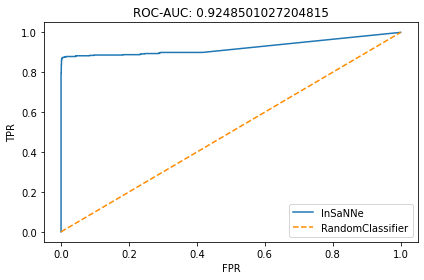

In [ ]:
roc = pd.DataFrame([fpr, tpr, thresholds]).T
roc.columns = ['FPR', 'TPR', 'Threshold']
roc.plot(x='FPR', y='TPR')
plt.plot([0, 1], [0, 1], color="darkorange",linestyle="--")
plt.title("ROC-AUC: " + str(a_roc))
plt.legend(['InSaNNe', 'RandomClassifier'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()
#plt.savefig(fp+'fig4A.svg', format='svg',dpi=300,bbox_inches='tight')

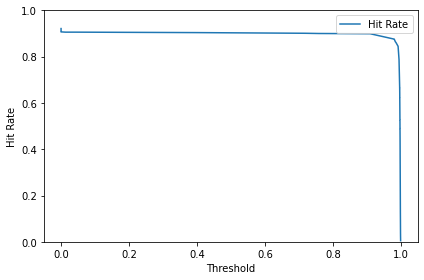

In [ ]:
custom_df_b.glycan = [daniel_to_iupac(k) for k in custom_df_b.glycan.values.tolist()]
preds = [get_preds(custom_df_b.seq_window_aa.values.tolist()[k], [custom_df_b.glycan.values.tolist()[k]]).predicted_presence.values[0] for k in range(len(custom_df_b))]
preds2 = [np.mean([j>k for j in preds]) for k in roc.Threshold.values.tolist()[::-1]]
struc = pd.DataFrame([preds2, roc.Threshold.values.tolist()[::-1][:-1]]).T
struc.columns = ['Hit Rate', 'Threshold']
struc.plot(x='Threshold', y='Hit Rate')
plt.xlabel("Threshold")
plt.ylabel("Hit Rate")
plt.ylim([0,1])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig(fp+'fig4B.svg', format='svg',dpi=300,bbox_inches='tight')